# Busniness Case 

---


O departamento de marketing da empresa Valuu deseja aplicar concenitos de marketing anaçytics, para identificar o resultado das camapanhas de marketing ao longo dos últimos anos. A empresa possui todos registos de vendas, e deseja saber quais os cleintes mais rentaveis, os pricipais segmentos de clientes e realizar previsões de facturamento de modo a definir as estratéfgias de marketing. O ponto crítico para empresa é conhecer o LTV (Life time Value), de modo a direccionar seus esforços de marketing e optimizar a aplicação de recursos corporativos. E para isso foi disponibilizado um banco de dados com as seguintes informações no arquivo compras : **codigo_do_cliente, valor_da_compra e data_da_compra.**

## Como entregar as informações solicitadas pelo departamento de marketing da empresa?

# 1.0 Imports


In [ ]:
import pandas                   as pd
import numpy                    as np
import seaborn                  as sns
import matplotlib.pyplot        as plt
import math

from IPython.core.display       import HTML
from IPython.display            import Image

from sklearn                    import preprocessing
from sklearn.cluster            import AgglomerativeClustering
from scipy.cluster.hierarchy    import dendrogram, linkage
from scipy.cluster.hierarchy    import fcluster




# 1.1 Help Functions

In [ ]:

# adjust jupyter notebook viz
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [27, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()


Populating the interactive namespace from numpy and matplotlib


# 2.0 Import Data

In [ ]:
url = 'https://rossmandatabase.s3-sa-east-1.amazonaws.com/compras.txt'
df = pd.read_csv( url, header= None, sep='\t', parse_dates=[2] )

# 2.1 Data pre-processing

### 2.1.1 Working wit columns

In [ ]:
# rename columns
cols = ['id_client','value','date']
df.columns = cols

In [ ]:
# extract year to column year
df['year'] = pd.DatetimeIndex(df['date']).year

In [ ]:
# visualizar os 20 primeiros ordenando por data
df.head(20).sort_values('date')

,id_client,value,date,year
16,4840,30.0,2005-10-14,2005
2,1200,100.0,2005-10-25,2005
12,4000,20.0,2005-11-25,2005
6,2620,30.0,2006-03-09,2006
8,3120,150.0,2006-11-08,2006
19,4970,30.0,2006-12-01,2006
17,4910,15.0,2006-12-13,2006
7,3050,50.0,2007-04-12,2007
11,3970,30.0,2007-06-07,2007
3,1420,50.0,2009-07-09,2009


### 2.1.2 Describe the data

In [ ]:
# describe data (count, mean, std, min, max)
df.describe()

,id_client,value,year
count,51243.000000,51243.000000,51243.000000
mean,108934.547938,62.337195,2010.869699
std,67650.610139,156.606801,2.883072
min,10.000000,5.000000,2005.000000
25%,57720.000000,25.000000,2009.000000
50%,102440.000000,30.000000,2011.000000
75%,160525.000000,60.000000,2013.000000
max,264200.000000,4500.000000,2015.000000


### 2.1.3 Total de Vendas por ano & Vendas medias por ano

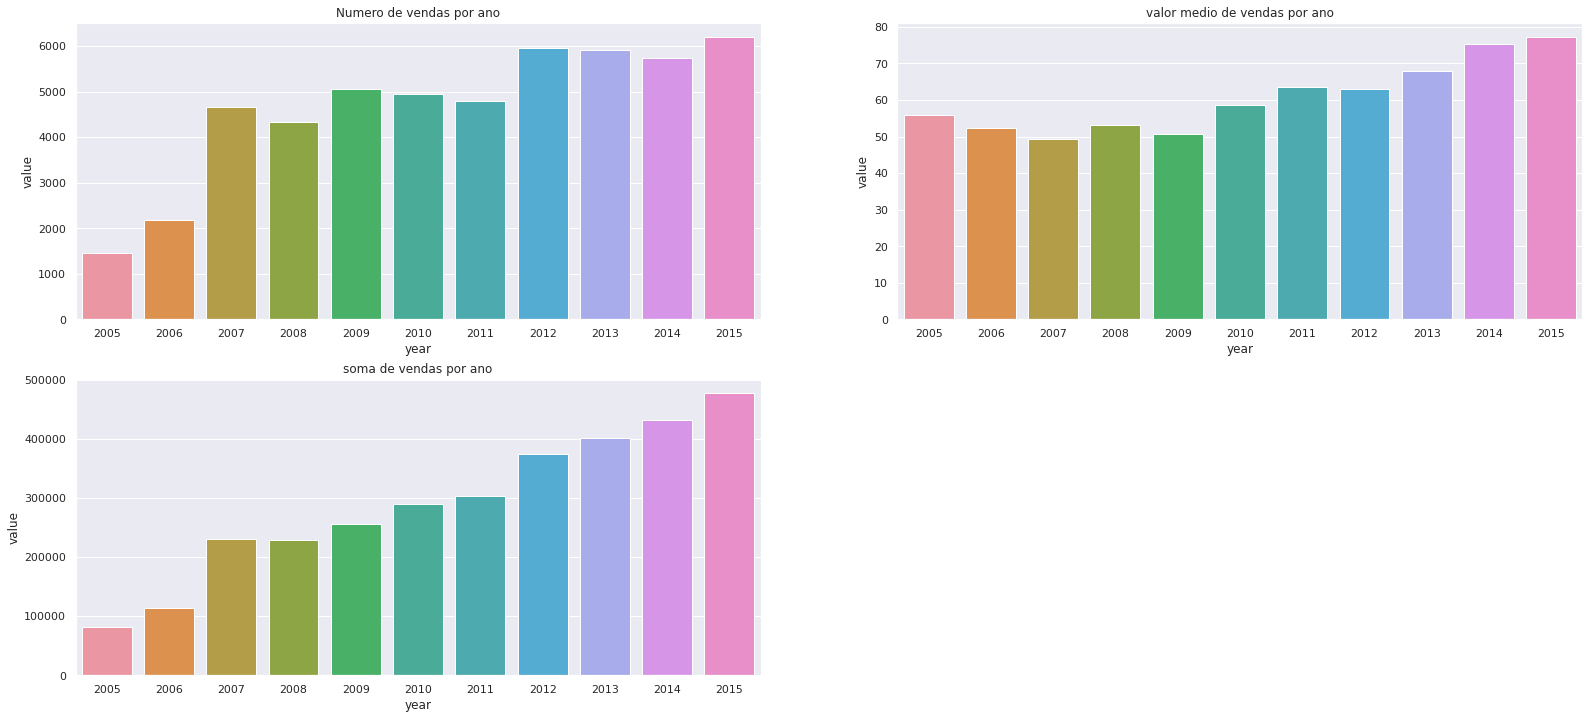

In [ ]:
# valor de vendas por ano
sales_for_year = df.groupby('year')\
    .agg({'value': 'count'})\
    .reset_index()

plt.subplot(2,2,1)

sns.barplot(x="year", y="value", data=sales_for_year).set(title = 'Numero de vendas por ano')



# valor medio de vendas por ano
sales_median_year = df.groupby('year')\
    .agg({'value': 'mean'})\
    .reset_index()

plt.subplot(2,2,2)
sns.barplot(x="year", y="value", data=sales_median_year).set(title = 'valor medio de vendas por ano');

# valor medio de vendas por ano
sales_median_year = df.groupby('year')\
    .agg({'value': 'sum'})\
    .reset_index()

plt.subplot(2,2,3)
sns.barplot(x="year", y="value", data=sales_median_year).set(title = 'soma de vendas por ano');




In [ ]:
# Agregar tudo em uma tabela
df.groupby('year')\
    .agg({'value': ['count', 'mean', 'sum']})\
    .reset_index()

year value                      
         count       mean        sum
0   2005  1470  55.826122   82064.40
1   2006  2182  52.250454  114010.49
2   2007  4674  49.264014  230260.00
3   2008  4331  53.071780  229853.88
4   2009  5054  50.745253  256466.51
5   2010  4939  58.740012  290116.92
6   2011  4785  63.519300  303939.85
7   2012  5960  62.913312  374963.34
8   2013  5912  67.931357  401610.18
9   2014  5739  75.390347  432665.20
10  2015  6197  77.197697  478394.13

# Segmentation

---
Os clientes não são uniformes, empresas possuem perfis de clientes diferentes. para nosso caso, segmentaremos por valor de compra. Segmentandr ou agrupar os clientes em grupos, é tarefa comum em departaemntos de Marketing, e serve para lhe dar com eles com diferentes estrategias de Marketing.



# 1.0 Data Exploration

In [ ]:
df1 = df.copy()

In [ ]:
df1.head()

,id_client,value,date,year
0,760,25.0,2009-11-06,2009
1,860,50.0,2012-09-28,2012
2,1200,100.0,2005-10-25,2005
3,1420,50.0,2009-07-09,2009
4,1940,70.0,2013-01-25,2013


## Quantos dias se passaram desde a ultima compra do cliente?

In [ ]:
# Criamos aleatoriamente a data de Janeiro de 2016. Lembrando que o dataset termina em 2015.
# Portanto queremos obtemos quantos dias passaram depois da ultima compra de cada cliente
dt_inicio = pd.to_datetime('2016-01-01')
df1['days_since'] = df_fim =  df1['date'] - dt_inicio
df1['days_since']  = df1['days_since'].abs()

# convert days to int
df1['days_since']  = df1['days_since'].dt.days.astype('int16')

In [ ]:
# Agregar tudo em uma tabela
# count - quantas compras o cliente fez
# mean - media do valor das compras
# min - (frequencia)quantidade de dias desde a ultima compra
agregation_clients = df1.groupby('id_client')\
    .agg({ 'days_since': ['min', 'count'], 'value':['mean'] })\
    .reset_index()


agregation_clients.head()


id_client days_since             value
                   min count        mean
0        10       3829     1   30.000000
1        80        343     7   71.428571
2        90        758    10  115.800000
3       120       1401     1   20.000000
4       130       2970     2   50.000000

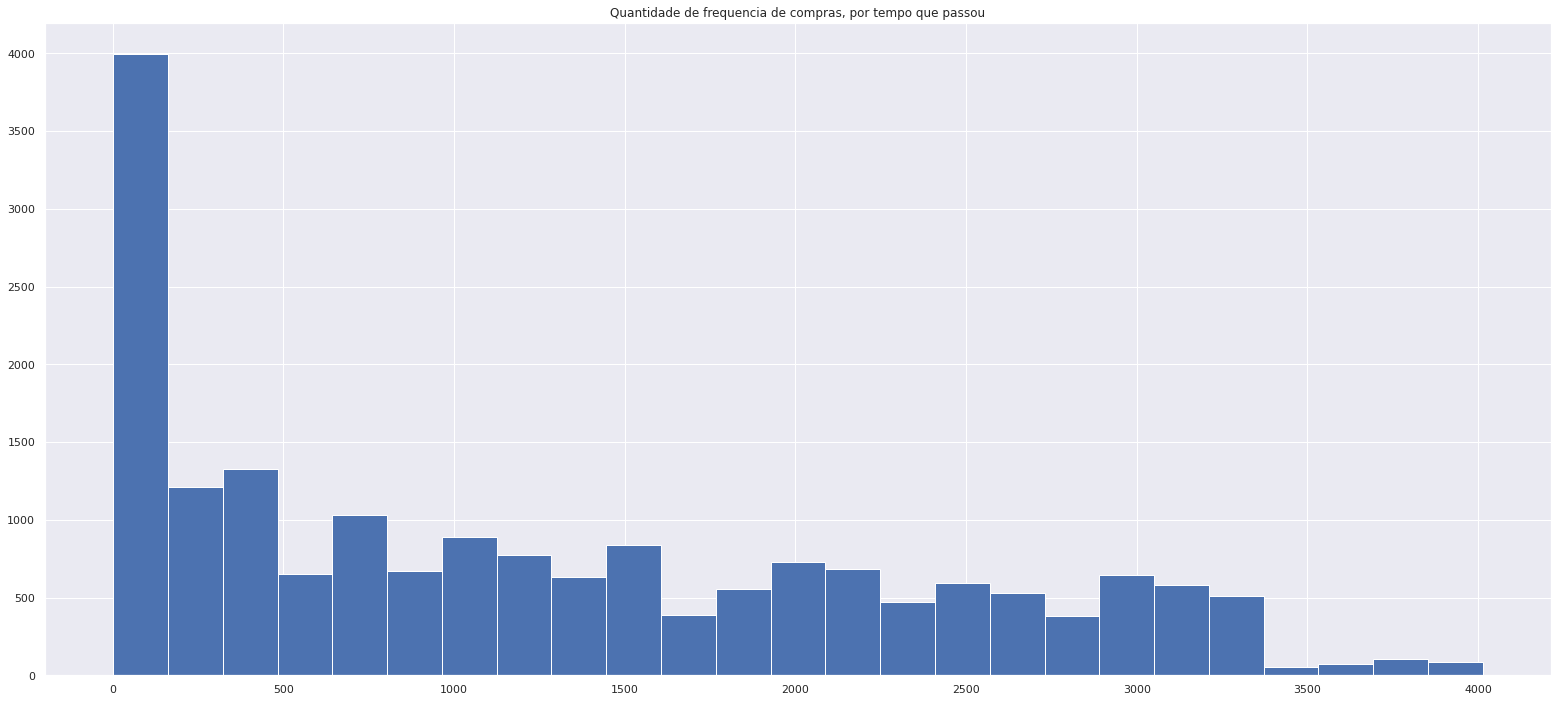

In [ ]:
agregation_clients['days_since']['min'].hist(bins= 25).set(title = 'Quantidade de frequencia de compras, por tempo que passou');

## Preparando os dados para segmentacao


In [ ]:
# copy agregation client as a df2
df2 = agregation_clients.copy()

In [ ]:
df2.head()

id_client days_since             value
                   min count        mean
0        10       3829     1   30.000000
1        80        343     7   71.428571
2        90        758    10  115.800000
3       120       1401     1   20.000000
4       130       2970     2   50.000000

In [ ]:
# set id_cliente as a index
# count - quantas compras o cliente fez
# mean - media do valor das compras
# min - (frequencia)quantidade de dias desde a ultima compra

## Scaling data

In [ ]:
# normalizando (distribuicao normal) os dados com a funcao log e atribuindo de volta ao data frame
df2.value = np.log(df2['value']['mean'])

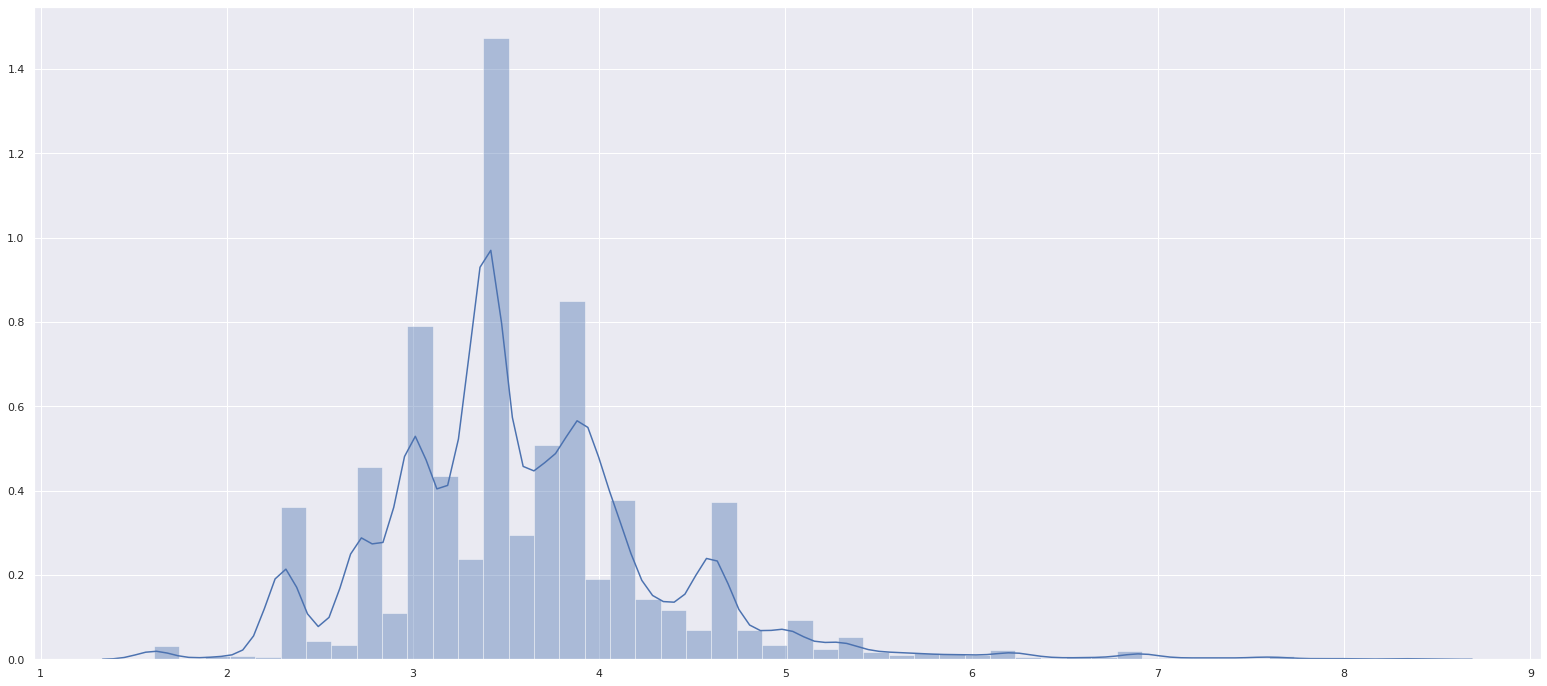

In [ ]:
sns.distplot(df2.value);

In [ ]:
df_scale = df2.copy()

In [ ]:
# Aplicando min-max Scale para padronizar os dados

# df2_to_scale = df2.drop(columns= 'id_client')

x = df_scale.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_scale= pd.DataFrame(x_scaled)



In [ ]:
# Tranforming dataframe
df2_sc = pd.concat([df_scale,df2['id_client']], axis = 1)
df2_sc = df2_sc[[1, 2, 3, 'id_client']]
df2_sc = df2_sc.set_index('id_client')


cols = ['day_since','freq','purschase_mean']
df2_sc.columns = cols

In [ ]:
df2_sc.head()

,day_since,freq,purschase_mean
id_client,,,
10,0.953900,0.000000,0.263401
80,0.085223,0.136364,0.390930
90,0.188637,0.204545,0.461959
120,0.348866,0.000000,0.203795
130,0.739846,0.022727,0.338496


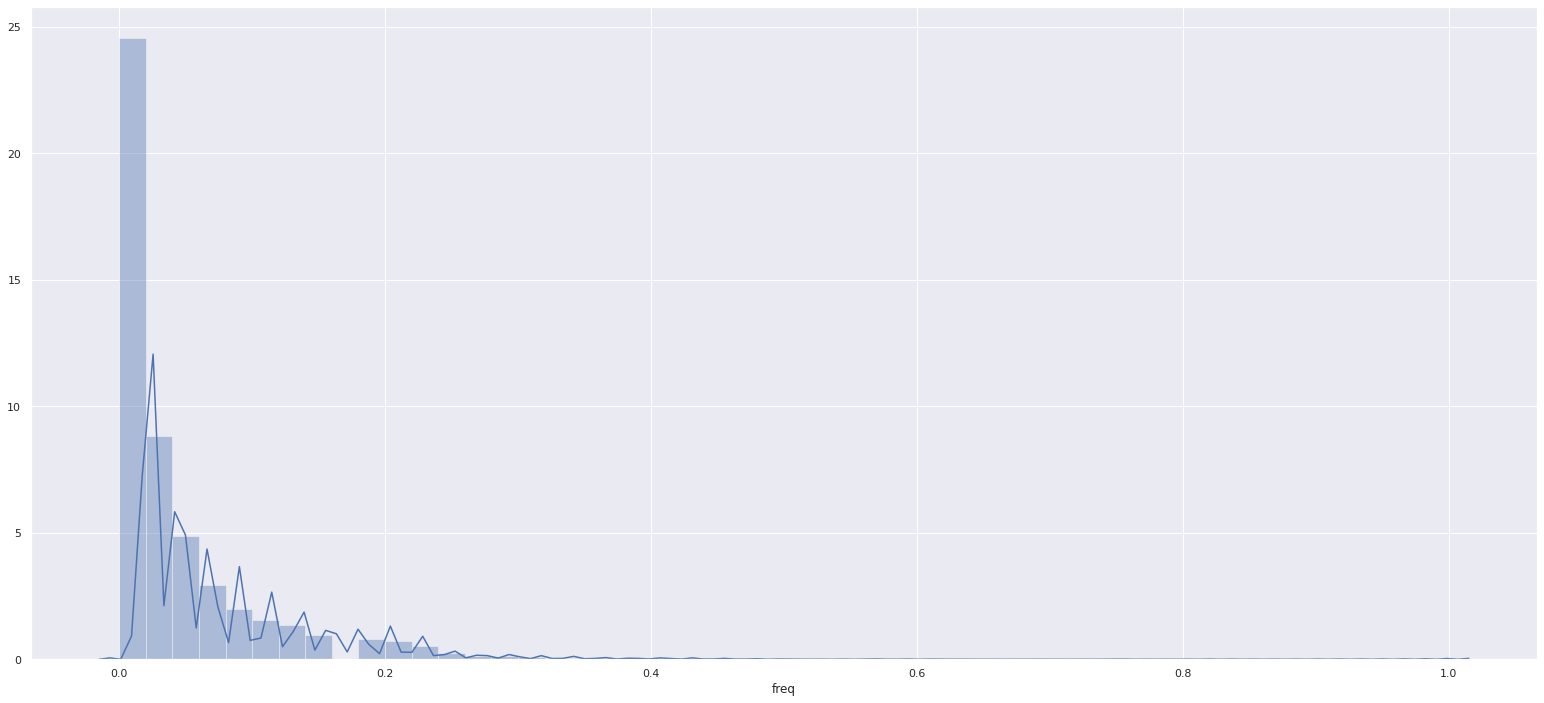

In [ ]:
sns.distplot(df2_sc.freq);

## Modelo de Agrupamento

In [ ]:
df2_sc.head()

,day_since,freq,purschase_mean
id_client,,,
10,0.953900,0.000000,0.263401
80,0.085223,0.136364,0.390930
90,0.188637,0.204545,0.461959
120,0.348866,0.000000,0.203795
130,0.739846,0.022727,0.338496


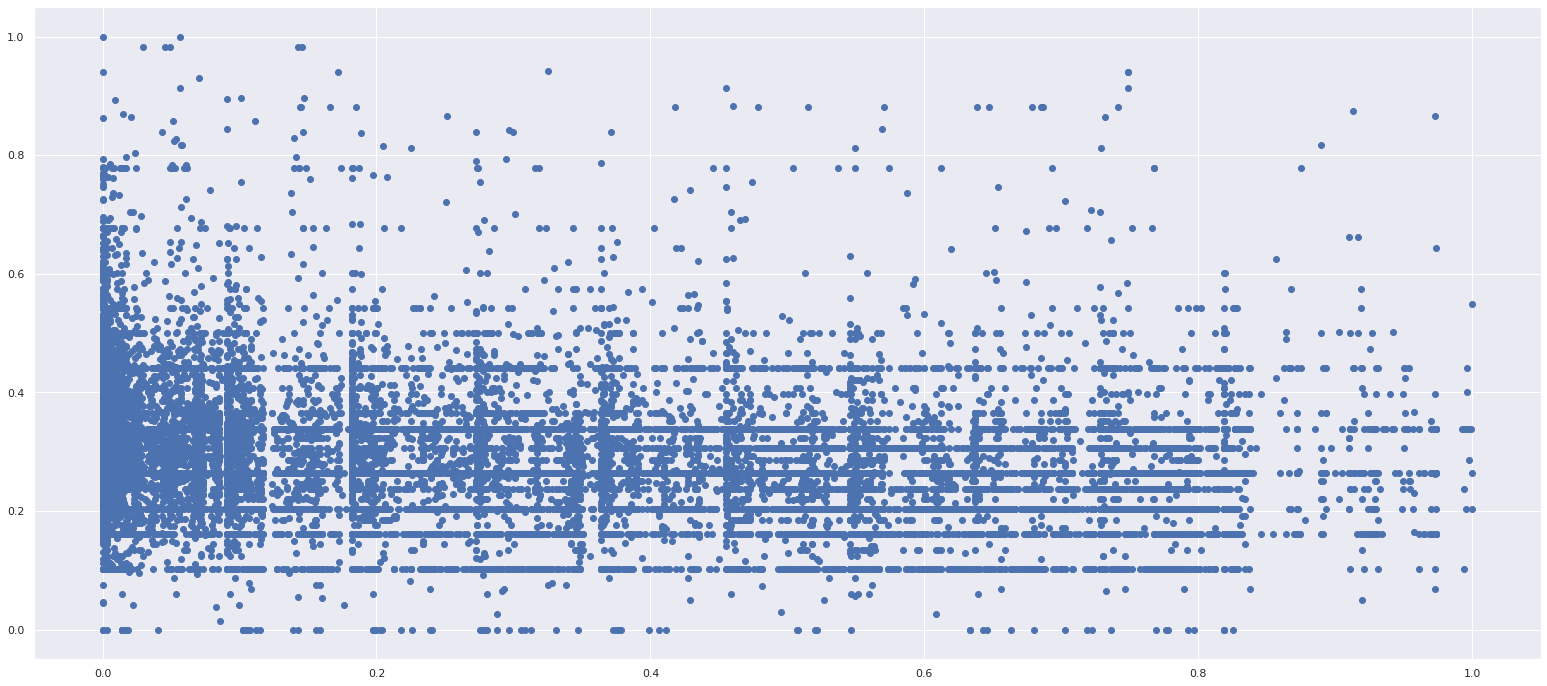

In [ ]:
plt.scatter( df2_sc.day_since, df2_sc.purschase_mean );

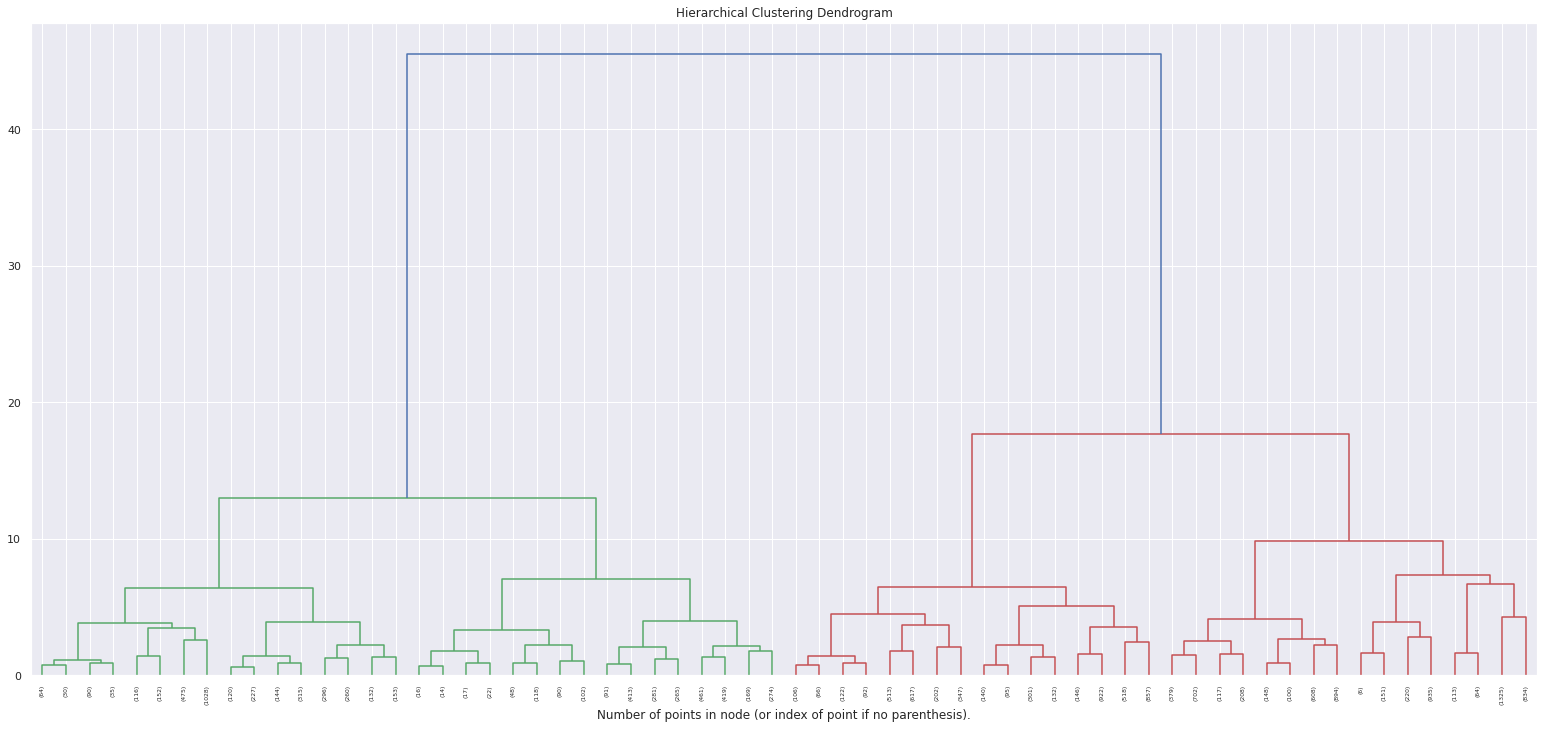

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

X = df2_sc

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)


model = model.fit(X)

plt.title('Hierarchical Clustering Dendrogram')
# plot the top levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()



